In [5]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp

In [32]:
def getWeightedGraph(graph,weight):
    revGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
    for u,v,d in revGraph.edges(data=True):
        d["weight"] = np.conj(weight)
    return nx.compose(graph,revGraph)

def multiple_oriented_decayRate(N,k,timeList,baseGraph,alphaList,initCond):
    decayRateMatrix = []
    for alpha in alphaList:
        weight = np.exp(1j*alpha)
        graph = getWeightedGraph(baseGraph,weight)
        qw = QWAK(graph)
        qw.runMultipleWalks(timeList=timeList,customStateList=initCond)
        decayRateMatrix.append(qw.getSurvivalProbList(N//2-k-1,N//2+k+2))
    return decayRateMatrix

In [37]:
n = 10
N=2**n
print(N)

alpha=np.pi/2
alphaList = [0, alpha/2, alpha/3]
alphaLabelList = [r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']

baseGraph = nx.path_graph(N,create_using=nx.DiGraph)

k = 3
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
    
l = 0
gamma = l * np.pi

t = 110
timeList = np.linspace(0,t,500)
initCond = [(N//2-k,np.cos(theta)),(N//2+k,np.exp(1j*gamma)*np.sin(theta))]

decayRateMatrix = multiple_oriented_decayRate(N,k,timeList,baseGraph,alphaList,initCond)

1024


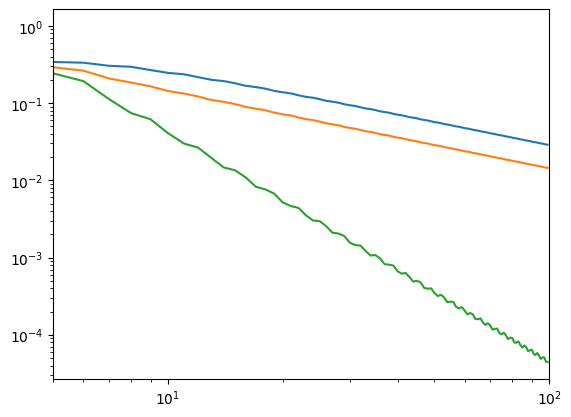

In [36]:
for x in decayRateMatrix:
    plt.loglog()
    plt.plot(x)
    plt.xlim([1,100])
   